## World rotation

Here we demonstrate how to use the EZKL package to rotate an on-chain world. 

![zk-gaming-diagram-transformed](https://hackmd.io/_uploads/HkApuQGV6.png)
> **A typical ZK application flow**. For the shape rotators out there — this is an easily digestible example. A user computes a ZK-proof that they have calculated a valid rotation of a world. They submit this proof to a verifier contract which governs an on-chain world, along with a new set of coordinates, and the world rotation updates. Observe that it’s possible for one player to initiate a *global* change.


In [1]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass



In [2]:
from torch import nn
import ezkl
import os
import json
import torch
import math

# these are constatns for the rotation
phi = torch.tensor(5 * math.pi / 180)
s = torch.sin(phi)
c = torch.cos(phi)


class RotateStuff(nn.Module):
    def __init__(self):
        super(RotateStuff, self).__init__()

        # create a rotation matrix -- the matrix is constant and is transposed for convenience
        self.rot = torch.stack([
            torch.stack([c, -s]),
            torch.stack([s, c])
        ]).t()

    def forward(self, x):
        x_rot = x @ self.rot   # same as x_rot = (rot @ x.t()).t() due to rot in O(n) (SO(n) even)
        return x_rot


circuit = RotateStuff()

This will showcase the principle directions of rotation by plotting the rotation of a single unit vector.

0.9961947202682495 0.08715573698282242
-0.08715573698282242 0.9961947202682495


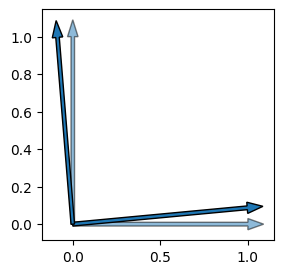

In [3]:
from matplotlib import pyplot
pyplot.figure(figsize=(3, 3))
pyplot.arrow(0, 0, 1, 0, width=0.02, alpha=0.5)
pyplot.arrow(0, 0, 0, 1, width=0.02, alpha=0.5)
print(circuit.rot[0, 0].item(), circuit.rot[0, 1].item())
print(circuit.rot[1, 0].item(), circuit.rot[1, 1].item())
pyplot.arrow(0, 0, circuit.rot[0, 0].item(), circuit.rot[0, 1].item(), width=0.02)
pyplot.arrow(0, 0, circuit.rot[1, 0].item(), circuit.rot[1, 1].item(), width=0.02)


In [4]:
model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.compiled')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')
srs_path = os.path.join('kzg.srs')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

In [6]:


# initial principle vectors for the rotation are as in the plot above
x = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)

# Flips the neural net into inference mode
circuit.eval()

    # Export the model
torch.onnx.export(circuit,               # model being run
                      x,                   # model input (or a tuple for multiple inputs)
                      model_path,            # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=10,          # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      )

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

    # Serialize data into file:
json.dump( data, open(data_path, 'w' ))


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### World rotation in 2D on-chain

For demo purposes we deploy these coordinates to a contract running locally using Anvil. This creates our on-chain world. We then rotate the world using the EZKL package and submit the proof to the contract. The contract then updates the world rotation. For demo purposes we do this repeatedly, rotating the world by 1 transform each time.

In [7]:
import subprocess
import time
import threading

# make sure anvil is running locally
# $ anvil -p 3030

RPC_URL = "http://localhost:3030"

# Save process globally
anvil_process = None

def start_anvil():
    global anvil_process
    if anvil_process is None:
        anvil_process = subprocess.Popen(["anvil", "-p", "3030", "--code-size-limit=41943040"])
        if anvil_process.returncode is not None:
            raise Exception("failed to start anvil process")
        time.sleep(3)

def stop_anvil():
    global anvil_process
    if anvil_process is not None:
        anvil_process.terminate()
        anvil_process = None


We define our `PyRunArgs` objects which contains the visibility parameters for out model. 
- `input_visibility` defines the visibility of the model inputs
- `param_visibility` defines the visibility of the model weights and constants and parameters 
- `output_visibility` defines the visibility of the model outputs

Here we create the following setup:
- `input_visibility`: "public"
- `param_visibility`: "fixed"
- `output_visibility`: public

In [8]:
py_run_args = ezkl.PyRunArgs()
py_run_args.input_visibility = "public"
py_run_args.output_visibility = "public"
py_run_args.param_visibility = "private" # private by default
py_run_args.scale_rebase_multiplier = 10

res = ezkl.gen_settings(model_path, settings_path, py_run_args=py_run_args)

In [9]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [11]:
start_anvil()



                             _   _
                            (_) | |
      __ _   _ __   __   __  _  | |
     / _` | | '_ \  \ \ / / | | | |
    | (_| | | | | |  \ V /  | | | |
     \__,_| |_| |_|   \_/   |_| |_|

    0.2.0 (95a93cd 2023-10-05T06:27:32.022343000Z)
    https://github.com/foundry-rs/foundry

Available Accounts

(0) "0xf39Fd6e51aad88F6F4ce6aB8827279cffFb92266" (10000.000000000000000000 ETH)
(1) "0x70997970C51812dc3A010C7d01b50e0d17dc79C8" (10000.000000000000000000 ETH)
(2) "0x3C44CdDdB6a900fa2b585dd299e03d12FA4293BC" (10000.000000000000000000 ETH)
(3) "0x90F79bf6EB2c4f870365E785982E1f101E93b906" (10000.000000000000000000 ETH)
(4) "0x15d34AAf54267DB7D7c367839AAf71A00a2C6A65" (10000.000000000000000000 ETH)
(5) "0x9965507D1a55bcC2695C58ba16FB37d819B0A4dc" (10000.000000000000000000 ETH)
(6) "0x976EA74026E726554dB657fA54763abd0C3a0aa9" (10000.000000000000000000 ETH)
(7) "0x14dC79964da2C08b23698B3D3cc7Ca32193d9955" (10000.000000000000000000 ETH)
(8) "0x23618e81E3f5cdF7f54C3

We also define a contract that holds out test data. This contract will contain in its storage the data that we will read from and attest to. In production you would not need to set up a local anvil instance. Instead you would replace RPC_URL with the actual RPC endpoint of the chain you are deploying your verifiers too, reading from the data on said chain.

In [12]:
ezkl.setup_test_evm_witness(
    data_path,
    compiled_model_path,
    # we write the call data to the same file as the input data
    data_path,
    input_source=ezkl.PyTestDataSource.OnChain,
    output_source=ezkl.PyTestDataSource.File,
    rpc_url=RPC_URL)

eth_chainId
eth_getTransactionCount
eth_getBlockByNumber
eth_feeHistory
eth_estimateGas
eth_sendRawTransaction

    Transaction: 0xfeb711f4abb4a36c40e10e552962eb9f7230555c6a2fa4900c967a393d75a5eb
    Contract created: 0x5fbdb2315678afecb367f032d93f642f64180aa3
    Gas used: 210019

    Block Number: 1
    Block Hash: 0x93f9730ff1079fbc5c18c98ca0a14dadf8522011975e4dcffeeecede493c2f4a
    Block Time: "Sat, 09 Dec 2023 06:33:13 +0000"

eth_getTransactionByHash
eth_getTransactionReceipt
eth_call
eth_call
eth_call
eth_call
eth_getTransactionCount
eth_getBlockByNumber
eth_feeHistory
eth_estimateGas
eth_sendRawTransaction

    Transaction: 0x6df885aee4d98c3a618252e6056e5fb08d4163687708f448433acbbb5444f4c1
    Contract created: 0xe7f1725e7734ce288f8367e1bb143e90bb3f0512
    Gas used: 894448

    Block Number: 2
    Block Hash: 0x3a1c7ebc28cfd1c7b3e6bb1643beb89dc919da2fb1de26c638f39715cf3eea6a
    Block Time: "Sat, 09 Dec 2023 06:33:14 +0000"

eth_getTransactionByHash
eth_getTransactionReceipt


True

As we use Halo2 with KZG-commitments we need an SRS string from (preferably) a multi-party trusted setup ceremony. For an overview of the procedures for such a ceremony check out [this page](https://blog.ethereum.org/2023/01/16/announcing-kzg-ceremony). The `get_srs` command retrieves a correctly sized SRS given the calibrated settings file from [here](https://github.com/han0110/halo2-kzg-srs). 

These SRS were generated with [this](https://github.com/privacy-scaling-explorations/perpetualpowersoftau) ceremony. 

In [13]:
# srs path
res = ezkl.get_srs(settings_path)

In [14]:
# now generate the witness file 

witness = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

eth_chainId
eth_call
eth_call
eth_call
eth_call
eth_getTransactionCount
eth_getBlockByNumber
eth_feeHistory
eth_estimateGas
eth_sendRawTransaction

    Transaction: 0x3b5a0add41bbd66aa06a5df154d90b0e805cb4cd749fa1215ec945e21da90d3d
    Contract created: 0x9fe46736679d2d9a65f0992f2272de9f3c7fa6e0
    Gas used: 894448

    Block Number: 3
    Block Hash: 0xc71c2aea1f5601e463bd9d1862087f40e7eb929054ec668ec4957ce46e39cec8
    Block Time: "Sat, 09 Dec 2023 06:33:22 +0000"

eth_getTransactionByHash
eth_getTransactionReceipt
eth_call
eth_call


Here we setup verifying and proving keys for the circuit. As the name suggests the proving key is needed for ... proving and the verifying key is needed for ... verifying. 

In [15]:
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

spawning module 2
spawning module 2


We can now create an EVM verifier contract from our circuit. This contract will be deployed to the chain we are using. In this case we are using a local anvil instance.

In [16]:
abi_path = 'test.abi'
sol_code_path = 'test.sol'

res = ezkl.create_evm_verifier(
        vk_path,
        
        settings_path,
        sol_code_path,
        abi_path,
    )
assert res == True

In [17]:
import json

addr_path_verifier = "addr_verifier.txt"

res = ezkl.deploy_evm(
    addr_path_verifier,
    sol_code_path,
    'http://127.0.0.1:3030'
)

assert res == True

eth_chainId
eth_getTransactionCount
eth_getBlockByNumber
eth_feeHistory
eth_estimateGas
eth_sendRawTransaction

    Transaction: 0xe0084c3ee72de7cf7f83f45071a4c6db03f6a13b7cb57676a1167cc5373d4414
    Contract created: 0xcf7ed3acca5a467e9e704c703e8d87f634fb0fc9
    Gas used: 1629036

    Block Number: 4
    Block Hash: 0x8ee0da3f4acdd70103348e588ac0ae0001ebadc6018799357443c69e4c83dd4b
    Block Time: "Sat, 09 Dec 2023 06:33:33 +0000"

eth_getTransactionByHash
eth_getTransactionReceipt


With the vanilla verifier deployed, we can now create the data attestation contract, which will read in the instances from the calldata to the verifier, attest to them, call the verifier and then return the result. 



In [18]:
abi_path = 'test.abi'
sol_code_path = 'test.sol'
input_path = 'input.json'

res = ezkl.create_evm_data_attestation(
        vk_path,
        
        settings_path,
        sol_code_path,
        abi_path,
        input_path,
    )

In [19]:
addr_path_da = "addr_da.txt"

res = ezkl.deploy_da_evm(
        addr_path_da,
        input_path,
        settings_path,
        sol_code_path,
        RPC_URL,
    )

eth_chainId
eth_getTransactionCount
eth_getBlockByNumber
eth_feeHistory
eth_estimateGas
eth_sendRawTransaction

    Transaction: 0x2e2b0d5c7cfe0e4409dc8ff85a819be84d95a8f714841e446f5e90b446fbe3a6
    Contract created: 0xdc64a140aa3e981100a9beca4e685f962f0cf6c9
    Gas used: 1749452

    Block Number: 5
    Block Hash: 0x6c894db2c1557c9468950d552ddded413964c4f8ad4f313829513b1722e861c0
    Block Time: "Sat, 09 Dec 2023 06:33:41 +0000"

eth_getTransactionByHash
eth_getTransactionReceipt


Now we can pull in the data from the contract and calculate a new set of coordinates. We then rotate the world by 1 transform and submit the proof to the contract. The contract could then update the world rotation (logic not inserted here). For demo purposes we do this repeatedly, rotating the world by 1 transform. 

In [20]:
# GENERATE A PROOF


proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        
        "single",
    )

print(res)
assert os.path.isfile(proof_path)

spawning module 2


{'instances': [[[8895048820941913435, 12590578388187041751, 10644156957292843428, 485414809211466155], [0, 0, 0, 0], [0, 0, 0, 0], [8895048820941913435, 12590578388187041751, 10644156957292843428, 485414809211466155], [3947005216498298223, 12819986980122620440, 11420438865531499559, 2854125043417166596], [720355975776690920, 6472239370783751601, 11570814210398824886, 1852564634523157045], [4171104710259907865, 14871419086232646368, 1710377740875869862, 1634433632279813620], [3947005216498298223, 12819986980122620440, 11420438865531499559, 2854125043417166596]]], 'proof': '21cf42fbc7b5322b166f650add6d87162b5798ff233fa69dae622aa3ee0be1cf02b836c36d0c4883e08480aa9d3357641d3d3687db3e45c4301f92652e1ea41312d809801d3d39bc9c550361414f7875302e60fa14239575c8e2a08c3625e1dc2fe5244d378d624672b26ed281c3199ab770d797fb1a90e5ef445a782dd7471b0dd1c724776a0a7e9cc2153c5f91c8583226f9dd4222b94923e75a433e8feac91da6138f2ebe81ebc71c72d0acbbe3674f0894f91f9d7dcbe5599afcb089d01c2d387abde4da53f908904e08b824ea64cab45

eth_chainId
eth_getTransactionCount
eth_getBlockByNumber
eth_feeHistory
eth_estimateGas
eth_sendRawTransaction

    Transaction: 0xb1dc0e239d7c68c331689fb9f2271f30d3b694904c474420ead0018a923b41d9
    Contract created: 0x5fc8d32690cc91d4c39d9d3abcbd16989f875707
    Gas used: 2135147

    Block Number: 6
    Block Hash: 0x60c7cd68eacf379edf7acbaed55be92b9584e6cc2f73dacd90557e332ef77a0b
    Block Time: "Sat, 09 Dec 2023 07:11:52 +0000"

eth_getTransactionByHash
eth_getTransactionReceipt
eth_chainId
eth_getTransactionCount
eth_getBlockByNumber
eth_feeHistory
eth_estimateGas
eth_sendRawTransaction

    Transaction: 0x738078287d38371d569af6200ed1168132a2de6ae77686147e190a388e9edf9a
    Contract created: 0x0165878a594ca255338adfa4d48449f69242eb8f
    Gas used: 2132519

    Block Number: 7
    Block Hash: 0x0ba77f0b599751b9d01fd44ebc2d728631465b15f1d9c6c6c43a05edaf4c67ec
    Block Time: "Sat, 09 Dec 2023 07:18:32 +0000"

eth_getTransactionByHash
eth_getTransactionReceipt
eth_chainId
eth_getTra

Call the view only verify method on the contract to verify the proof. Since it is a view function this is safe to use in production since you don't have to pass your private key.

In [ ]:
# read the verifier address
addr_verifier = None
with open(addr_path_verifier, 'r') as f:
    addr = f.read()
#read the data attestation address
addr_da = None
with open(addr_path_da, 'r') as f:
    addr_da = f.read()

res = ezkl.verify_evm(
    proof_path,
    addr,
    RPC_URL,
    addr_da,
)

As a sanity check lets plot the rotations of the unit vectors. We can see that the unit vectors rotate as expected by the output of the circuit. 

In [ ]:
witness['outputs'][0][0]

In [9]:
settings = json.load(open(settings_path, 'r'))
out_scale = settings["model_output_scales"][0]

from matplotlib import pyplot
pyplot.figure(figsize=(3, 3))
pyplot.arrow(0, 0, 1, 0, width=0.02, alpha=0.5)
pyplot.arrow(0, 0, 0, 1, width=0.02, alpha=0.5)

arrow_x = ezkl.vecu64_to_float(witness['outputs'][0][0], out_scale)
arrow_y = ezkl.vecu64_to_float(witness['outputs'][0][1], out_scale)
pyplot.arrow(0, 0, arrow_x, arrow_y, width=0.02)
arrow_x = ezkl.vecu64_to_float(witness['outputs'][0][2], out_scale)
arrow_y = ezkl.vecu64_to_float(witness['outputs'][0][3], out_scale)
pyplot.arrow(0, 0, arrow_x, arrow_y, width=0.02)

NameError: name 'settings_path' is not defined